In [204]:
#credit: https://www.kaggle.com/code/shivanshuman/vgg19-transfer-learning

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.utils import image_utils
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("./input/"))
# Any results you write to the current directory are saved as output.

['.DS_Store', '777.JPG', 'three.JPG', '666.JPG', 'two.JPG', '2.webp', '11.jpg', '2222.png', '1111.png', '640.jpg', '333.jpg', 'b.jpeg', '111111.jpeg', '7.jpg', '444.jpeg', 'style.png', '3.jpeg']


In [205]:
StylePath = './input/'
ContentPath = './input/'

In [206]:
style_image_path = StylePath+'style.png'
base_image_path = ContentPath+'444.jpeg'

In [207]:
# dimensions of the generated picture.
width, height = image_utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [208]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = image_utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = image_utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

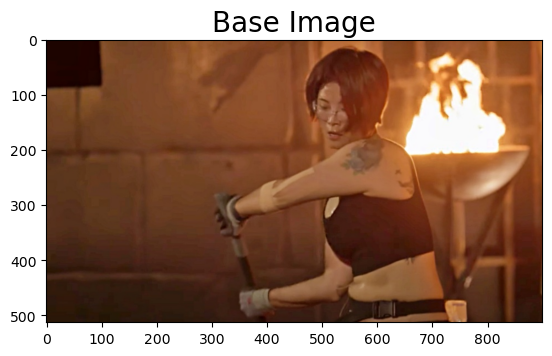

In [209]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = image_utils.load_img(base_image_path)
plt.imshow(img1)

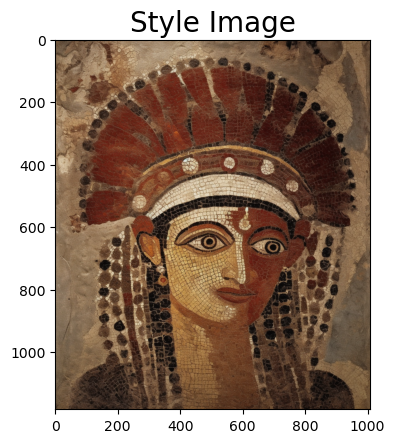

In [210]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = image_utils.load_img(style_image_path)
plt.imshow(img1)

In [211]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [212]:
K.image_data_format()

'channels_last'

In [213]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [214]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

In [215]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = './vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')

2023-06-16 14:56:03.856871: W tensorflow/c/c_api.cc:300] Operation '{name:'block5_conv1_8/kernel/Assign' id:8225 op device:{requested: '', assigned: ''} def:{{{node block5_conv1_8/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](block5_conv1_8/kernel, block5_conv1_8/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model loaded.


In [216]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [217]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2_8/Relu:0", shape=(3, 25, 43, 512), dtype=float32)


In [218]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [219]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))


In [220]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss = loss + content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

Layer Feature for Content Layers :: Tensor("block5_conv2_8/Relu:0", shape=(3, 25, 43, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice_176:0", shape=(25, 43, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_177:0", shape=(25, 43, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1_8/Relu:0", shape=(3, 400, 701, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_178:0", shape=(400, 701, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_179:0", shape=(400, 701, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1_8/Relu:0", shape=(3, 200, 350, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_182:0", shape=(200, 350, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_183:0", shape=(200, 350, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1_8/Relu:0", shap

In [221]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [222]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients_8/concat_8_grad/Slice_2:0' shape=(1, 400, 701, 3) dtype=float32>]

In [223]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs


In [224]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [225]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [226]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [227]:
evaluator = Evaluator()

In [228]:
iterations=20
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()



Start of iteration 0


2023-06-16 14:56:08.327757: W tensorflow/c/c_api.cc:300] Operation '{name:'Variable_26/Assign' id:8444 op device:{requested: '', assigned: ''} def:{{{node Variable_26/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_26, Variable_26/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       841200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28266D+23    |proj g|=  4.37175D+17


 This problem is unconstrained.



At iterate    1    f=  1.16952D+23    |proj g|=  4.29219D+17

At iterate    2    f=  7.58508D+22    |proj g|=  5.43244D+17

At iterate    3    f=  4.09127D+22    |proj g|=  3.17688D+17

At iterate    4    f=  2.05052D+22    |proj g|=  2.71112D+17

At iterate    5    f=  1.18706D+22    |proj g|=  1.07781D+17

At iterate    6    f=  9.11366D+21    |proj g|=  1.78400D+17

At iterate    7    f=  6.74590D+21    |proj g|=  7.53673D+16

At iterate    8    f=  5.57402D+21    |proj g|=  5.11874D+16

At iterate    9    f=  4.46768D+21    |proj g|=  3.63965D+16

At iterate   10    f=  3.77621D+21    |proj g|=  1.25330D+17

At iterate   11    f=  2.88212D+21    |proj g|=  2.73147D+16

At iterate   12    f=  2.65678D+21    |proj g|=  1.48898D+16

At iterate   13    f=  2.22423D+21    |proj g|=  1.65953D+16

At iterate   14    f=  1.78377D+21    |proj g|=  2.56928D+16

At iterate   15    f=  1.47444D+21    |proj g|=  1.58641D+16

At iterate   16    f=  1.35859D+21    |proj g|=  2.06004D+16

       

 This problem is unconstrained.



At iterate    1    f=  1.33224D+21    |proj g|=  1.72262D+16

At iterate    2    f=  1.20902D+21    |proj g|=  6.46567D+15

At iterate    3    f=  1.15669D+21    |proj g|=  6.27291D+15

At iterate    4    f=  1.03769D+21    |proj g|=  1.48744D+16

At iterate    5    f=  9.74922D+20    |proj g|=  1.10461D+16

At iterate    6    f=  9.32556D+20    |proj g|=  7.69400D+15

At iterate    7    f=  8.20241D+20    |proj g|=  5.49688D+15

At iterate    8    f=  7.55906D+20    |proj g|=  6.71566D+15

At iterate    9    f=  7.10689D+20    |proj g|=  1.41905D+16

At iterate   10    f=  6.50206D+20    |proj g|=  4.54267D+15

At iterate   11    f=  6.22463D+20    |proj g|=  1.08975D+16

At iterate   12    f=  5.74963D+20    |proj g|=  6.62106D+15

At iterate   13    f=  5.27467D+20    |proj g|=  6.76265D+15

At iterate   14    f=  4.89117D+20    |proj g|=  3.79493D+15

At iterate   15    f=  4.76924D+20    |proj g|=  7.77426D+15

At iterate   16    f=  4.58533D+20    |proj g|=  3.44620D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  4.12410D+20    |proj g|=  5.07414D+15

At iterate    2    f=  4.03537D+20    |proj g|=  2.44056D+15

At iterate    3    f=  3.98831D+20    |proj g|=  3.40373D+15

At iterate    4    f=  3.85870D+20    |proj g|=  4.34621D+15

At iterate    5    f=  3.82713D+20    |proj g|=  8.26096D+15

At iterate    6    f=  3.69165D+20    |proj g|=  2.89373D+15

At iterate    7    f=  3.63237D+20    |proj g|=  2.08066D+15

At iterate    8    f=  3.54669D+20    |proj g|=  2.31852D+15

At iterate    9    f=  3.44734D+20    |proj g|=  2.97622D+15

At iterate   10    f=  3.33110D+20    |proj g|=  3.80135D+15

At iterate   11    f=  3.17553D+20    |proj g|=  3.30910D+15

At iterate   12    f=  3.03337D+20    |proj g|=  6.00335D+15

At iterate   13    f=  2.87314D+20    |proj g|=  3.41562D+15

At iterate   14    f=  2.81902D+20    |proj g|=  2.49338D+15

At iterate   15    f=  2.76089D+20    |proj g|=  3.06568D+15

At iterate   16    f=  2.66803D+20    |proj g|=  3.80967D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  2.25190D+20    |proj g|=  5.27323D+15

At iterate    2    f=  2.14770D+20    |proj g|=  2.91554D+15

At iterate    3    f=  2.11904D+20    |proj g|=  1.69171D+15

At iterate    4    f=  2.07531D+20    |proj g|=  2.29421D+15

At iterate    5    f=  2.05687D+20    |proj g|=  6.24965D+15

At iterate    6    f=  2.00389D+20    |proj g|=  1.76700D+15

At iterate    7    f=  1.99259D+20    |proj g|=  9.05864D+14

At iterate    8    f=  1.96783D+20    |proj g|=  1.93842D+15

At iterate    9    f=  1.93767D+20    |proj g|=  2.41149D+15

At iterate   10    f=  1.90477D+20    |proj g|=  1.74273D+15

At iterate   11    f=  1.87351D+20    |proj g|=  1.28152D+15

At iterate   12    f=  1.84103D+20    |proj g|=  1.38705D+15

At iterate   13    f=  1.79964D+20    |proj g|=  2.79270D+15

At iterate   14    f=  1.74810D+20    |proj g|=  2.97856D+15

At iterate   15    f=  1.71187D+20    |proj g|=  1.99316D+15

At iterate   16    f=  1.67739D+20    |proj g|=  1.43641D+15

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       841200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59996D+20    |proj g|=  2.15522D+15

At iterate    1    f=  1.59258D+20    |proj g|=  1.83965D+15

At iterate    2    f=  1.57141D+20    |proj g|=  1.67365D+15

At iterate    3    f=  1.55529D+20    |proj g|=  2.10227D+15

At iterate    4    f=  1.53301D+20    |proj g|=  1.90537D+15

At iterate    5    f=  1.51805D+20    |proj g|=  2.29533D+15

At iterate    6    f=  1.50089D+20    |proj g|=  1.00766D+15

At iterate    7    f=  1.48568D+20    |proj g|=  1.15173D+15

At iterate    8    f=  1.47111D+20    |proj g|=  1.09660D+15

At iterate    9    f=  1.45034D+20    |proj g|=  1.56042D+15

At iterate   10    f=  1.43031D+20    |proj g|=  1.77084D+15

At iterate   11    f=  1.40957D+20    |proj g|=  1.12917D+15

At iterate   12    f=  1.38113D+20    |proj g|=  1.62870D+15

At iterate   13    f=  1.3

 This problem is unconstrained.



At iterate    1    f=  1.20397D+20    |proj g|=  1.94188D+15

At iterate    2    f=  1.17400D+20    |proj g|=  1.42639D+15

At iterate    3    f=  1.15349D+20    |proj g|=  1.58451D+15

At iterate    4    f=  1.14439D+20    |proj g|=  1.82519D+15

At iterate    5    f=  1.13801D+20    |proj g|=  8.69226D+14

At iterate    6    f=  1.13186D+20    |proj g|=  7.97898D+14

At iterate    7    f=  1.12156D+20    |proj g|=  1.51936D+15

At iterate    8    f=  1.11289D+20    |proj g|=  1.84693D+15

At iterate    9    f=  1.10197D+20    |proj g|=  9.74588D+14

At iterate   10    f=  1.09417D+20    |proj g|=  7.71134D+14

At iterate   11    f=  1.08552D+20    |proj g|=  1.03753D+15

At iterate   12    f=  1.07154D+20    |proj g|=  1.10336D+15

At iterate   13    f=  1.05145D+20    |proj g|=  1.81567D+15

At iterate   14    f=  1.03490D+20    |proj g|=  1.77907D+15

At iterate   15    f=  1.02281D+20    |proj g|=  8.00154D+14

At iterate   16    f=  1.01559D+20    |proj g|=  8.81630D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  9.94413D+19    |proj g|=  5.93626D+14

At iterate    2    f=  9.82400D+19    |proj g|=  9.42657D+14

At iterate    3    f=  9.78808D+19    |proj g|=  1.01938D+15

At iterate    4    f=  9.75242D+19    |proj g|=  6.94788D+14

At iterate    5    f=  9.69498D+19    |proj g|=  7.93938D+14

At iterate    6    f=  9.63020D+19    |proj g|=  1.13287D+15

At iterate    7    f=  9.54519D+19    |proj g|=  1.57486D+15

At iterate    8    f=  9.44823D+19    |proj g|=  9.11736D+14

At iterate    9    f=  9.36166D+19    |proj g|=  1.01786D+15

At iterate   10    f=  9.27148D+19    |proj g|=  1.15722D+15

At iterate   11    f=  9.16242D+19    |proj g|=  1.02215D+15

At iterate   12    f=  9.10752D+19    |proj g|=  1.35522D+15

At iterate   13    f=  9.01609D+19    |proj g|=  7.55887D+14

At iterate   14    f=  8.93465D+19    |proj g|=  8.01316D+14

At iterate   15    f=  8.84354D+19    |proj g|=  1.16558D+15

At iterate   16    f=  8.75514D+19    |proj g|=  8.20058D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  8.61700D+19    |proj g|=  6.66139D+14

At iterate    2    f=  8.54444D+19    |proj g|=  7.61263D+14

At iterate    3    f=  8.47085D+19    |proj g|=  1.22982D+15

At iterate    4    f=  8.42733D+19    |proj g|=  1.16035D+15

At iterate    5    f=  8.39877D+19    |proj g|=  6.79927D+14

At iterate    6    f=  8.36360D+19    |proj g|=  6.00692D+14

At iterate    7    f=  8.31310D+19    |proj g|=  8.04422D+14

At iterate    8    f=  8.24519D+19    |proj g|=  1.13216D+15

At iterate    9    f=  8.23040D+19    |proj g|=  2.05927D+15

At iterate   10    f=  8.15263D+19    |proj g|=  6.01157D+14

At iterate   11    f=  8.11941D+19    |proj g|=  5.74650D+14

At iterate   12    f=  8.06388D+19    |proj g|=  8.79165D+14

At iterate   13    f=  7.98610D+19    |proj g|=  1.01203D+15

At iterate   14    f=  7.95468D+19    |proj g|=  1.98416D+15

At iterate   15    f=  7.80585D+19    |proj g|=  1.21694D+15

At iterate   16    f=  7.76627D+19    |proj g|=  4.46106D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  7.52715D+19    |proj g|=  7.90328D+14

At iterate    2    f=  7.47013D+19    |proj g|=  8.54676D+14

At iterate    3    f=  7.39951D+19    |proj g|=  8.56168D+14

At iterate    4    f=  7.39166D+19    |proj g|=  1.99861D+15

At iterate    5    f=  7.33367D+19    |proj g|=  7.46427D+14

At iterate    6    f=  7.31604D+19    |proj g|=  4.97835D+14

At iterate    7    f=  7.26959D+19    |proj g|=  6.73322D+14

At iterate    8    f=  7.21723D+19    |proj g|=  8.33296D+14

At iterate    9    f=  7.11803D+19    |proj g|=  8.39466D+14

At iterate   10    f=  7.08345D+19    |proj g|=  1.02394D+15

At iterate   11    f=  7.02667D+19    |proj g|=  5.34105D+14

At iterate   12    f=  6.99951D+19    |proj g|=  6.98794D+14

At iterate   13    f=  6.95736D+19    |proj g|=  6.85612D+14

At iterate   14    f=  6.90121D+19    |proj g|=  6.78423D+14

At iterate   15    f=  6.85168D+19    |proj g|=  1.11006D+15

At iterate   16    f=  6.81679D+19    |proj g|=  5.65731D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  6.76102D+19    |proj g|=  3.87343D+14

At iterate    2    f=  6.72512D+19    |proj g|=  4.52570D+14

At iterate    3    f=  6.69816D+19    |proj g|=  6.27490D+14

At iterate    4    f=  6.67442D+19    |proj g|=  1.07344D+15

At iterate    5    f=  6.64766D+19    |proj g|=  6.78219D+14

At iterate    6    f=  6.59665D+19    |proj g|=  5.72283D+14

At iterate    7    f=  6.55110D+19    |proj g|=  5.55712D+14

At iterate    8    f=  6.50789D+19    |proj g|=  1.47385D+15

At iterate    9    f=  6.45808D+19    |proj g|=  4.59516D+14

At iterate   10    f=  6.43927D+19    |proj g|=  4.57898D+14

At iterate   11    f=  6.41410D+19    |proj g|=  4.20263D+14

At iterate   12    f=  6.38077D+19    |proj g|=  4.70625D+14

At iterate   13    f=  6.35074D+19    |proj g|=  2.01695D+15

At iterate   14    f=  6.27223D+19    |proj g|=  6.30264D+14

At iterate   15    f=  6.23469D+19    |proj g|=  5.97304D+14

At iterate   16    f=  6.17754D+19    |proj g|=  8.24868D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  5.58214D+19    |proj g|=  8.63644D+14

At iterate    2    f=  5.52496D+19    |proj g|=  8.15982D+14

At iterate    3    f=  5.49342D+19    |proj g|=  6.74456D+14

At iterate    4    f=  5.43618D+19    |proj g|=  9.25787D+14

At iterate    5    f=  5.41656D+19    |proj g|=  1.84184D+15

At iterate    6    f=  5.38221D+19    |proj g|=  5.70365D+14

At iterate    7    f=  5.36485D+19    |proj g|=  4.66149D+14

At iterate    8    f=  5.34618D+19    |proj g|=  6.95740D+14

At iterate    9    f=  5.31379D+19    |proj g|=  6.40900D+14

At iterate   10    f=  5.26371D+19    |proj g|=  9.99393D+14

At iterate   11    f=  5.23819D+19    |proj g|=  6.80416D+14

At iterate   12    f=  5.21703D+19    |proj g|=  3.86420D+14

At iterate   13    f=  5.19323D+19    |proj g|=  6.79079D+14

At iterate   14    f=  5.17349D+19    |proj g|=  1.05034D+15

At iterate   15    f=  5.15081D+19    |proj g|=  8.93157D+14

At iterate   16    f=  5.12333D+19    |proj g|=  1.13311D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  5.09364D+19    |proj g|=  2.00567D+14

At iterate    2    f=  5.08219D+19    |proj g|=  2.66358D+14

At iterate    3    f=  5.06869D+19    |proj g|=  5.32530D+14

At iterate    4    f=  5.04645D+19    |proj g|=  1.12630D+15

At iterate    5    f=  5.02304D+19    |proj g|=  6.41668D+14

At iterate    6    f=  5.00768D+19    |proj g|=  5.21292D+14

At iterate    7    f=  4.99247D+19    |proj g|=  4.42382D+14

At iterate    8    f=  4.97914D+19    |proj g|=  5.39113D+14

At iterate    9    f=  4.94463D+19    |proj g|=  4.76558D+14

At iterate   10    f=  4.93244D+19    |proj g|=  1.24507D+15

At iterate   11    f=  4.89907D+19    |proj g|=  3.38259D+14

At iterate   12    f=  4.88720D+19    |proj g|=  3.07251D+14

At iterate   13    f=  4.87000D+19    |proj g|=  3.61881D+14

At iterate   14    f=  4.84262D+19    |proj g|=  5.26052D+14

At iterate   15    f=  4.79511D+19    |proj g|=  6.31861D+14

At iterate   16    f=  4.74110D+19    |proj g|=  1.23112D+15

At iter

 This problem is unconstrained.



At iterate    1    f=  4.26681D+19    |proj g|=  9.47960D+14

At iterate    2    f=  4.22107D+19    |proj g|=  6.24987D+14

At iterate    3    f=  4.18804D+19    |proj g|=  7.71261D+14

At iterate    4    f=  4.11453D+19    |proj g|=  1.19914D+15

At iterate    5    f=  4.10300D+19    |proj g|=  1.63743D+15

At iterate    6    f=  4.05723D+19    |proj g|=  6.16115D+14

At iterate    7    f=  4.04159D+19    |proj g|=  3.52827D+14

At iterate    8    f=  4.02210D+19    |proj g|=  5.16400D+14

At iterate    9    f=  3.99688D+19    |proj g|=  6.08152D+14

At iterate   10    f=  3.93564D+19    |proj g|=  6.69384D+14

At iterate   11    f=  3.91221D+19    |proj g|=  1.23300D+15

At iterate   12    f=  3.86716D+19    |proj g|=  5.35791D+14

At iterate   13    f=  3.85001D+19    |proj g|=  2.67368D+14

At iterate   14    f=  3.84245D+19    |proj g|=  3.69429D+14

At iterate   15    f=  3.83646D+19    |proj g|=  2.03099D+14

At iterate   16    f=  3.82897D+19    |proj g|=  1.72166D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  3.81268D+19    |proj g|=  5.10873D+14

At iterate    2    f=  3.80650D+19    |proj g|=  2.20817D+14

At iterate    3    f=  3.80464D+19    |proj g|=  2.71903D+14

At iterate    4    f=  3.79780D+19    |proj g|=  3.04414D+14

At iterate    5    f=  3.79222D+19    |proj g|=  2.19560D+14

At iterate    6    f=  3.78541D+19    |proj g|=  1.78189D+14

At iterate    7    f=  3.77975D+19    |proj g|=  4.64000D+14

At iterate    8    f=  3.77193D+19    |proj g|=  4.63526D+14

At iterate    9    f=  3.75647D+19    |proj g|=  3.75639D+14

At iterate   10    f=  3.74103D+19    |proj g|=  6.32466D+14

At iterate   11    f=  3.71992D+19    |proj g|=  3.63133D+14

At iterate   12    f=  3.70020D+19    |proj g|=  3.02001D+14

At iterate   13    f=  3.68338D+19    |proj g|=  3.69774D+14

At iterate   14    f=  3.65408D+19    |proj g|=  7.66882D+14

At iterate   15    f=  3.62720D+19    |proj g|=  4.03377D+14

At iterate   16    f=  3.61088D+19    |proj g|=  3.68810D+14

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       841200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45135D+19    |proj g|=  1.48844D+15

At iterate    1    f=  3.44146D+19    |proj g|=  1.25761D+15

At iterate    2    f=  3.40357D+19    |proj g|=  4.85347D+14

At iterate    3    f=  3.39104D+19    |proj g|=  5.33456D+14

At iterate    4    f=  3.34496D+19    |proj g|=  8.42379D+14

At iterate    5    f=  3.33790D+19    |proj g|=  7.68679D+14

At iterate    6    f=  3.32554D+19    |proj g|=  3.63680D+14

At iterate    7    f=  3.31745D+19    |proj g|=  2.25801D+14

At iterate    8    f=  3.30910D+19    |proj g|=  3.62515D+14

At iterate    9    f=  3.29830D+19    |proj g|=  4.19462D+14

At iterate   10    f=  3.28375D+19    |proj g|=  4.32463D+14

At iterate   11    f=  3.27682D+19    |proj g|=  4.52773D+14

At iterate   12    f=  3.26758D+19    |proj g|=  1.96724D+14

At iterate   13    f=  3.2

 This problem is unconstrained.



At iterate    1    f=  3.21811D+19    |proj g|=  1.40607D+14

At iterate    2    f=  3.21625D+19    |proj g|=  2.01745D+14

At iterate    3    f=  3.21208D+19    |proj g|=  2.72846D+14

At iterate    4    f=  3.20638D+19    |proj g|=  3.24981D+14

At iterate    5    f=  3.20102D+19    |proj g|=  6.17449D+14

At iterate    6    f=  3.19372D+19    |proj g|=  2.02273D+14

At iterate    7    f=  3.18833D+19    |proj g|=  2.65469D+14

At iterate    8    f=  3.18219D+19    |proj g|=  3.11273D+14

At iterate    9    f=  3.16739D+19    |proj g|=  3.11339D+14

At iterate   10    f=  3.16194D+19    |proj g|=  5.16174D+14

At iterate   11    f=  3.15270D+19    |proj g|=  2.01324D+14

At iterate   12    f=  3.14680D+19    |proj g|=  1.87196D+14

At iterate   13    f=  3.13951D+19    |proj g|=  4.85196D+14

At iterate   14    f=  3.13174D+19    |proj g|=  2.97828D+14

At iterate   15    f=  3.12214D+19    |proj g|=  2.64409D+14

At iterate   16    f=  3.11019D+19    |proj g|=  3.32715D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  3.01629D+19    |proj g|=  5.46552D+14

At iterate    2    f=  2.99862D+19    |proj g|=  4.63688D+14

At iterate    3    f=  2.98701D+19    |proj g|=  6.38315D+14

At iterate    4    f=  2.96316D+19    |proj g|=  6.42501D+14

At iterate    5    f=  2.95584D+19    |proj g|=  6.88080D+14

At iterate    6    f=  2.94626D+19    |proj g|=  3.56632D+14

At iterate    7    f=  2.93676D+19    |proj g|=  3.82295D+14

At iterate    8    f=  2.92863D+19    |proj g|=  3.84612D+14

At iterate    9    f=  2.91763D+19    |proj g|=  2.38163D+14

At iterate   10    f=  2.91391D+19    |proj g|=  6.86237D+14

At iterate   11    f=  2.90259D+19    |proj g|=  2.73089D+14

At iterate   12    f=  2.89870D+19    |proj g|=  2.94820D+14

At iterate   13    f=  2.89123D+19    |proj g|=  2.44142D+14

At iterate   14    f=  2.88186D+19    |proj g|=  3.34198D+14

At iterate   15    f=  2.87711D+19    |proj g|=  3.42080D+14

At iterate   16    f=  2.87221D+19    |proj g|=  1.35634D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  2.86449D+19    |proj g|=  1.63787D+14

At iterate    2    f=  2.86345D+19    |proj g|=  1.20229D+14

At iterate    3    f=  2.86231D+19    |proj g|=  1.64450D+14

At iterate    4    f=  2.85974D+19    |proj g|=  2.56646D+14

At iterate    5    f=  2.85623D+19    |proj g|=  2.28604D+14

At iterate    6    f=  2.85530D+19    |proj g|=  6.78870D+14

At iterate    7    f=  2.84796D+19    |proj g|=  1.79186D+14

At iterate    8    f=  2.84504D+19    |proj g|=  1.82660D+14

At iterate    9    f=  2.84062D+19    |proj g|=  2.69346D+14

At iterate   10    f=  2.83444D+19    |proj g|=  2.96242D+14

At iterate   11    f=  2.82805D+19    |proj g|=  5.33666D+14

At iterate   12    f=  2.82043D+19    |proj g|=  2.00730D+14

At iterate   13    f=  2.81667D+19    |proj g|=  2.46865D+14

At iterate   14    f=  2.81011D+19    |proj g|=  2.54583D+14

At iterate   15    f=  2.80086D+19    |proj g|=  5.69209D+14

At iterate   16    f=  2.78731D+19    |proj g|=  3.59818D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  2.72585D+19    |proj g|=  3.65103D+14

At iterate    2    f=  2.71652D+19    |proj g|=  3.69120D+14

At iterate    3    f=  2.70774D+19    |proj g|=  5.14481D+14

At iterate    4    f=  2.69311D+19    |proj g|=  3.95743D+14

At iterate    5    f=  2.68337D+19    |proj g|=  6.31266D+14

At iterate    6    f=  2.67194D+19    |proj g|=  3.23455D+14

At iterate    7    f=  2.66485D+19    |proj g|=  2.91777D+14

At iterate    8    f=  2.65976D+19    |proj g|=  3.84347D+14

At iterate    9    f=  2.65395D+19    |proj g|=  2.34804D+14

At iterate   10    f=  2.64747D+19    |proj g|=  3.20143D+14

At iterate   11    f=  2.63722D+19    |proj g|=  3.85313D+14

At iterate   12    f=  2.63370D+19    |proj g|=  3.13545D+14

At iterate   13    f=  2.62957D+19    |proj g|=  1.77133D+14

At iterate   14    f=  2.62454D+19    |proj g|=  1.46565D+14

At iterate   15    f=  2.62193D+19    |proj g|=  2.63700D+14

At iterate   16    f=  2.62024D+19    |proj g|=  1.71383D+14

At iter

 This problem is unconstrained.



At iterate    1    f=  2.61420D+19    |proj g|=  1.15913D+14

At iterate    2    f=  2.61361D+19    |proj g|=  1.49954D+14

At iterate    3    f=  2.61139D+19    |proj g|=  1.79306D+14

At iterate    4    f=  2.60981D+19    |proj g|=  2.60210D+14

At iterate    5    f=  2.60740D+19    |proj g|=  2.02262D+14

At iterate    6    f=  2.60139D+19    |proj g|=  2.77197D+14

At iterate    7    f=  2.60009D+19    |proj g|=  5.49328D+14

At iterate    8    f=  2.59624D+19    |proj g|=  2.04768D+14

At iterate    9    f=  2.59415D+19    |proj g|=  1.46580D+14

At iterate   10    f=  2.59082D+19    |proj g|=  2.46696D+14

At iterate   11    f=  2.58498D+19    |proj g|=  3.74120D+14

At iterate   12    f=  2.57345D+19    |proj g|=  4.20505D+14

At iterate   13    f=  2.56556D+19    |proj g|=  8.53551D+14

At iterate   14    f=  2.55291D+19    |proj g|=  4.35192D+14

At iterate   15    f=  2.54101D+19    |proj g|=  2.88393D+14

At iterate   16    f=  2.53314D+19    |proj g|=  3.00418D+14

At iter

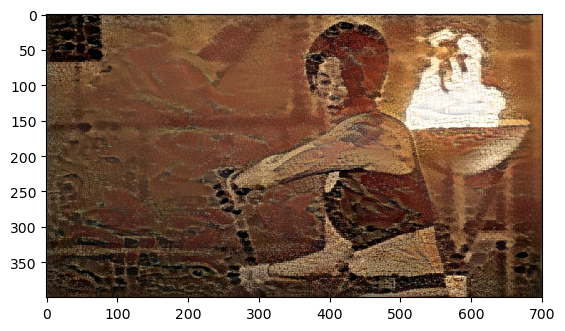

In [229]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

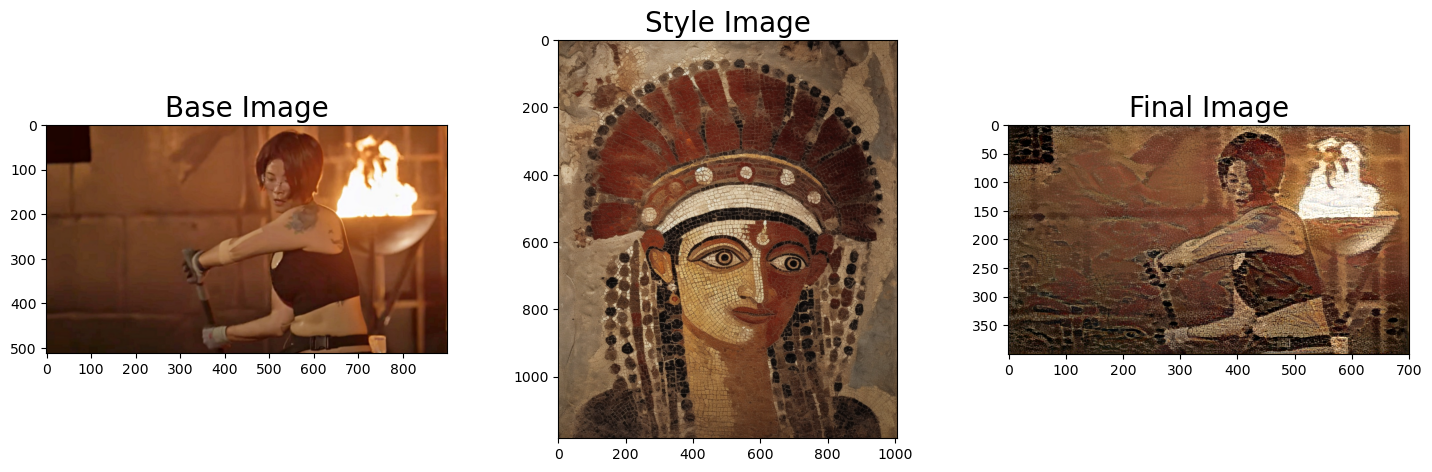

In [230]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = image_utils.load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = image_utils.load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)